L’objectif de cette étude est de créer un algorithme de classification sur les catégories
feuilles (category_id) à partir de ces 128 features (f0, … f127).


### Load data

In [1]:
import pandas as pd

from pathlib import Path, PosixPath

data_path : PosixPath = Path.cwd() / "data"

category_parent_df : pd.DataFrame = pd.read_csv(data_path / "category_parent.csv")
test_df : pd.DataFrame = pd.read_csv(data_path / "data_test.csv.gz", compression='gzip')
train_df : pd.DataFrame = pd.read_csv(data_path / "data_train.csv.gz", compression='gzip')


### EDA

In [2]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(train_df, title="Pandas Profiling Report") #, explorative=True)
# profile.to_notebook_iframe()

print(train_df.shape)
print(train_df.dtypes.value_counts())
print(train_df.isna().sum(axis=0).max())
print(train_df.isnull().sum(axis=0).max())

print(test_df.shape)
print(test_df.dtypes.value_counts())
print(test_df.isna().sum(axis=0).max())
print(test_df.isnull().sum(axis=0).max())

assert set(train_df.category_id) - set(test_df.category_id) == set(test_df.category_id) - set(train_df.category_id)

# Dataset de taille raisonable (241483 entrées) ie des modèles simples avec peu de paramètres devraient suffire à une bonne modélisation
# Only numerical features of type float & no missing values : Simplifiate the processing and less features engineering
# 128 features : High Dimensionality: With 128 features, dimensionality reduction might be useful before applying some algorithms.
# Uncorrelated Features: This suggests that simple linear models might work well, but it's also possible that interactions between features could be important.
# 101 catégorie produits, les mêmes sur le test et le train
# Distribution des categories :
#    - Raisonablement similaire entre en test et le train
#    - Problème très déséquilibré, il y a un facteur 10 entre l'occurence de certaines catégories

# TODO
# Feature Scaling: Even though the features are numeric and uncorrelated, it’s worth checking if they are on a similar scale. Many machine learning models (e.g., SVM, neural networks) perform better with scaled data.
# Outliers: Have you checked for any potential outliers within your features? While they might not be an issue for decision trees or ensemble methods, they could impact models like logistic regression or SVM.
# Multicollinearity (even though features are uncorrelated): While you've already identified that the features are uncorrelated, exploring whether any subtle linear dependencies might still affect some models can be useful.
# PCA : Since the features are uncorrelated, you won't necessarily need to apply dimensionality reduction techniques like PCA unless for computational efficiency.
# Unbalanced : You may need to handle this during model training with techniques such as class weighting, oversampling/undersampling, or using specialized algorithms like SMOTE or ensemble methods.
# Lazy predict

(241483, 130)
float64    128
object       1
int64        1
Name: count, dtype: int64
0
0
(44738, 130)
float64    128
object       1
int64        1
Name: count, dtype: int64
0
0


Maximum of correlation:  9.670942157331787e-07


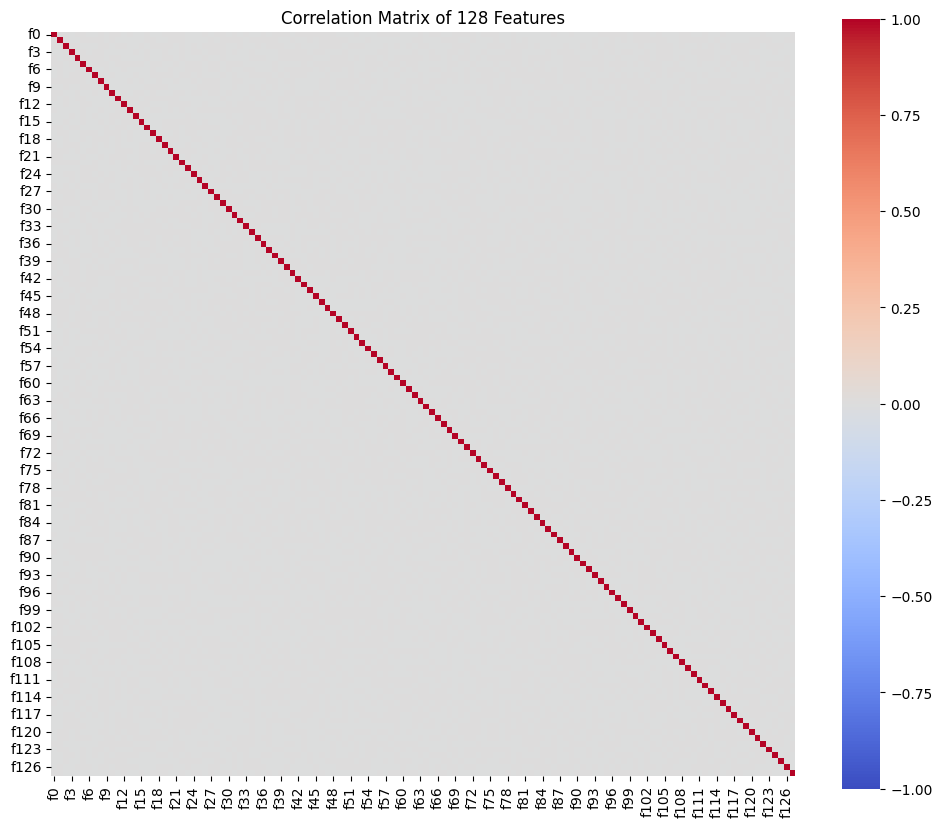

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = train_df.iloc[:, 2:].corr()

print("Maximum of correlation: ", corr_matrix.abs().replace(1.0, None).max().max())

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt='.2f', square=True)
plt.title("Correlation Matrix of 128 Features")
plt.show()

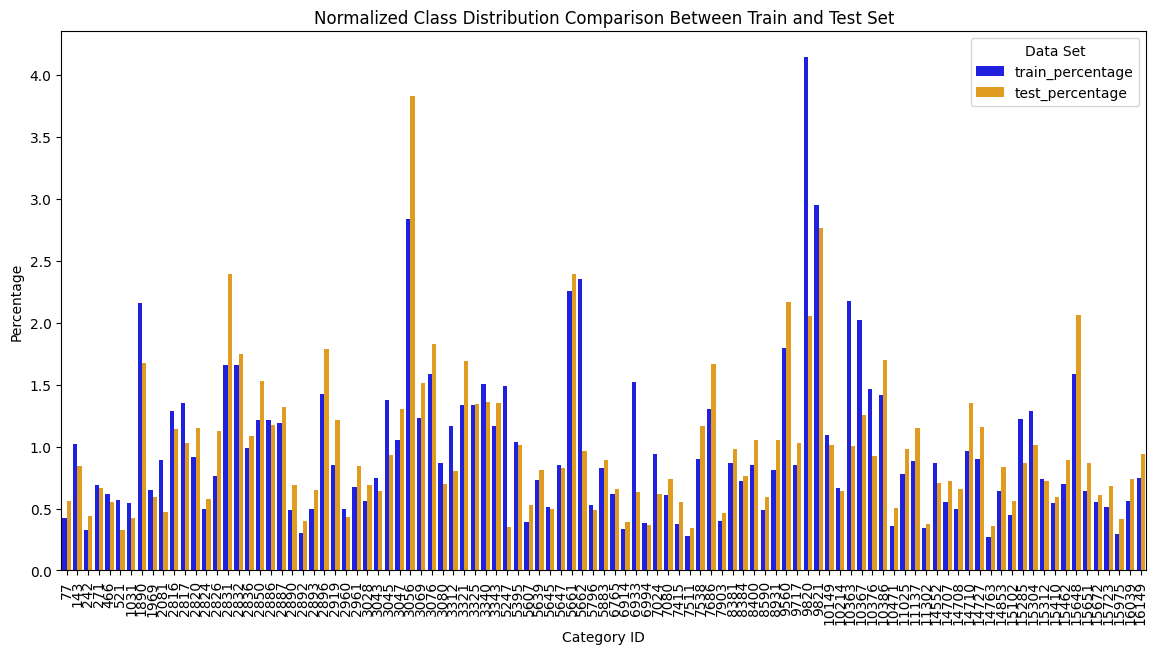

In [4]:
train_class_counts = train_df['category_id'].value_counts(normalize=True)
test_class_counts = test_df['category_id'].value_counts(normalize=True)

melted_class_distribution = (
    pd.DataFrame({
    'category': train_class_counts.index,
    'train_percentage': train_class_counts.values * 100,
    'test_percentage': test_class_counts.reindex(train_class_counts.index, fill_value=0).values * 100
    })
    .sort_values(by='train_percentage', ascending=False)
    .melt(id_vars='category', 
          value_vars=['train_percentage', 'test_percentage'],
          var_name='Set', value_name='Percentage')
)

plt.figure(figsize=(14, 7))
sns.barplot(x='category', y='Percentage', hue='Set', data=melted_class_distribution, palette={'train_percentage': 'blue', 'test_percentage': 'orange'})

plt.xlabel('Category ID')
plt.ylabel('Percentage')
plt.title('Normalized Class Distribution Comparison Between Train and Test Set')
plt.xticks(rotation=90)
plt.legend(title='Data Set')
plt.show()


In [5]:
from scipy.stats import zscore

# Compute Z-scores
z_scores = train_df.iloc[:, 2:].apply(zscore)

# Identify outliers (e.g., Z-score > 3 or < -3)
outliers = (z_scores > 3) | (z_scores < -3)
outlier_summary = outliers.sum()

print("Number of outliers per feature:")
print(outlier_summary)


Number of outliers per feature:
f0      1111
f1      1356
f2       719
f3      2298
f4      5124
        ... 
f123    2649
f124    2763
f125    2748
f126    2884
f127    2720
Length: 128, dtype: int64


### Processing

In [19]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Step 1: Split the data
X = train_df.iloc[:, 2:]  # Features
y = train_df['category_id']  # Labels

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Scale the training data
#scaler = StandardScaler()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 3: Fit PCA on the training data
pca = PCA(n_components=122)  # Choose number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


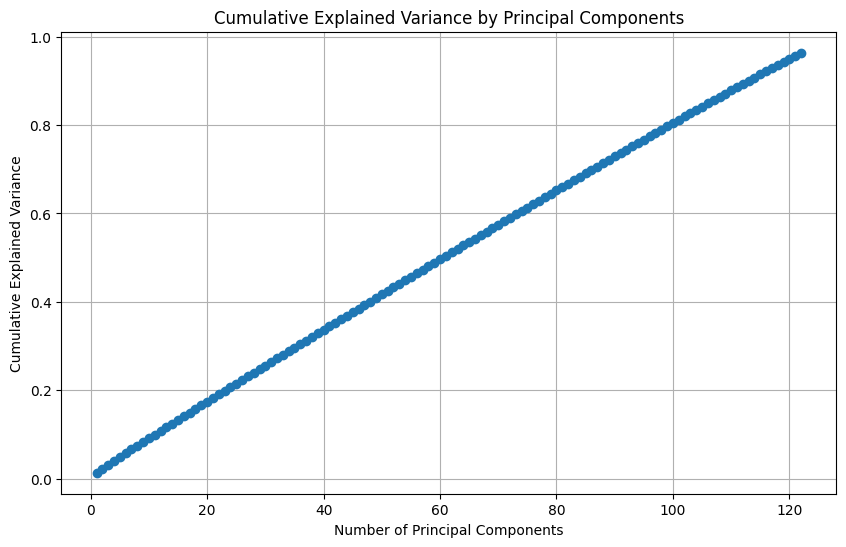

In [20]:
import matplotlib.pyplot as plt

# Calculate explained variance ratio and cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [21]:

# Determine number of components that explain 95% of the variance
n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.95) + 1

# Initialize PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)

print(f'Number of components selected: {n_components}')

Number of components selected: 120


In [24]:
from sklearn.linear_model import LassoCV

# Step 1: Scale the data as before
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Step 2: Apply LassoCV to automatically tune alpha
lasso_cv = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso_cv.fit(X_train_scaled, y_train)

# Step 3: Check the best alpha and the selected features
best_alpha = lasso_cv.alpha_
print(f'Best alpha found by LassoCV: {best_alpha}')

# Step 4: Get the important features (non-zero coefficients)
selected_features_mask = lasso_cv.coef_ != 0
selected_features = X_train.columns[selected_features_mask]

print(f'Number of selected features: {len(selected_features)}')
print('Selected features:', selected_features)


Best alpha found by LassoCV: 1.3376672617179528
Number of selected features: 128
Selected features: Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126',
       'f127'],
      dtype='object', length=128)


In [25]:
from sklearn.linear_model import ElasticNetCV

# Apply ElasticNetCV with cross-validation
elasticnet_cv = ElasticNetCV(l1_ratio=0.7, cv=5, random_state=42)  # Adjust l1_ratio as needed
elasticnet_cv.fit(X_train_scaled, y_train)

# Check the best alpha and selected features
best_alpha_en = elasticnet_cv.alpha_
print(f'Best alpha found by ElasticNetCV: {best_alpha_en}')

# Get the important features (non-zero coefficients)
selected_features_mask_en = elasticnet_cv.coef_ != 0
selected_features_en = X_train.columns[selected_features_mask_en]

print(f'Number of selected features: {len(selected_features_en)}')
print('Selected features:', selected_features_en)


Best alpha found by ElasticNetCV: 1.910953231025647
Number of selected features: 127
Selected features: Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9',
       ...
       'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126',
       'f127'],
      dtype='object', length=127)


In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Use RandomForest for feature ranking
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Get feature importances and rank features
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance

# Number of top features to keep
n_top_features = 50
top_indices = indices[:n_top_features]

# Get the names of the top features
top_features = X_train.columns[top_indices]

print(f'Number of top features: {len(top_features)}')
print('Top features:', top_features)


NameError: name 'X_train_scaled' is not defined

### Modeling

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1. Logistic Regression
# Pros: Simple, interpretable, and effective for linearly separable data.
# Cons: May not capture complex patterns.

model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Fit the model
model.fit(X_train.iloc[:, :3], y_train)

# Predict and evaluate
y_pred = model.predict(X_val.iloc[:, :3])
print(classification_report(y_val, y_pred))


              precision    recall  f1-score   support

          77       0.04      0.16      0.07       203
         143       0.15      0.55      0.24       493
         242       0.00      0.00      0.00       159
         271       0.02      0.01      0.01       334
         466       0.03      0.01      0.01       300
         521       0.08      0.28      0.13       275
        1031       0.08      0.81      0.15       263
        1890       0.11      0.01      0.02      1043
        1969       0.03      0.01      0.01       315
        2081       0.04      0.00      0.01       431
        2816       0.10      0.10      0.10       621
        2817       0.00      0.00      0.00       652
        2820       0.04      0.05      0.05       441
        2824       0.03      0.03      0.03       239
        2826       0.05      0.19      0.08       370
        2831       0.18      0.39      0.25       801
        2832       0.07      0.01      0.01       799
        2836       0.00    

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 2. Random Forest
#  Pros: Handles large feature sets well, robust to overfitting, good for complex patterns.
#  Cons: Can be less interpretable compared to simpler models.

model = RandomForestClassifier(class_weight='balanced')

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

(101, 101)

In [ ]:
# 3 Support Vector Machine (SVM)
#   Pros: Effective in high-dimensional spaces, good for complex boundaries.
#   Cons: Computationally intensive, especially for large datasets.

from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Initialize the model
model = SVC(class_weight='balanced')

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


In [34]:
category_parent_df

,category_id,parent_id
0,-1,NaN
1,64,63.0
2,65,64.0
3,77,65.0
4,1876,1855.0
...,...,...
263,10906,-1.0
264,14394,-1.0
265,15201,-1.0
266,15645,-1.0
